# Import Libraries 

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    precision_recall_curve, roc_auc_score, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

# Settings

In [2]:
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
os.makedirs("plots", exist_ok=True)

# Load Dataset 

In [3]:
columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes',
    'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
    'num_compromised','root_shell','su_attempted','num_root','num_file_creations',
    'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
    'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
    'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
    'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
    'dst_host_rerror_rate','dst_host_srv_rerror_rate','label'
]

train = pd.read_csv("train_data.txt", names=columns)
test = pd.read_csv("test_data.txt", names=columns)

# Preprocessing 

In [4]:
for df in [train, test]:
    # Standardize labels and create binary target
    df['label'] = df['label'].str.rstrip('.')
    df['target'] = (df['label'] != 'normal').astype(int)

numeric_cols = train.select_dtypes(include=['int64','float64']).columns.drop('target')

# Visualizations 

# Dataset Sizes

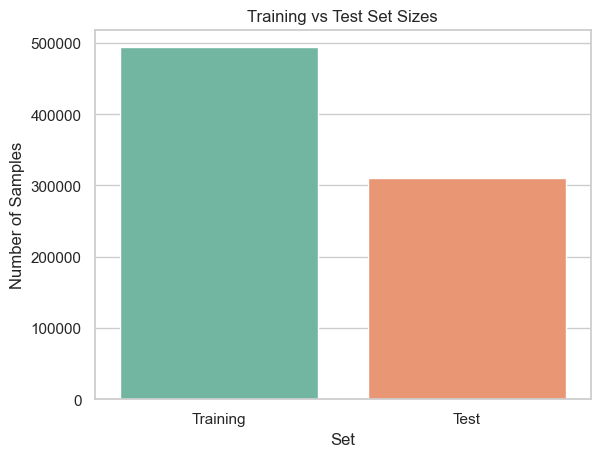

In [5]:
sizes = pd.DataFrame({'Set': ['Training', 'Test'], 'Samples': [len(train), len(test)]})
sns.barplot(x='Set', y='Samples', data=sizes, palette="Set2")
plt.title("Training vs Test Set Sizes")
plt.ylabel("Number of Samples")
plt.savefig("plots/train_test_sizes.png")
plt.show()

# Normal vs Attack counts

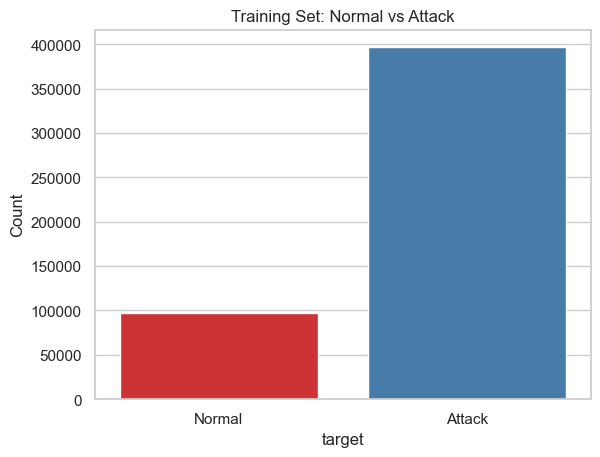

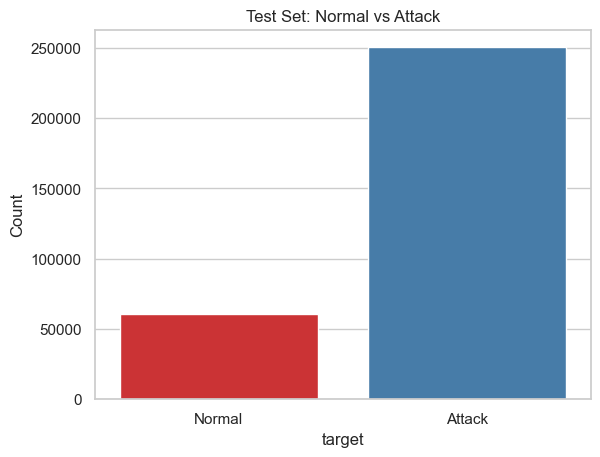

In [6]:
for df, name in zip([train, test], ['Training', 'Test']):
    sns.countplot(x=df['target'], palette="Set1")
    plt.title(f"{name} Set: Normal vs Attack")
    plt.xticks([0,1], ["Normal","Attack"])
    plt.ylabel("Count")
    plt.savefig(f"plots/{name.lower()}_normal_vs_attack.png")
    plt.show()

# Pie chart for class distribution

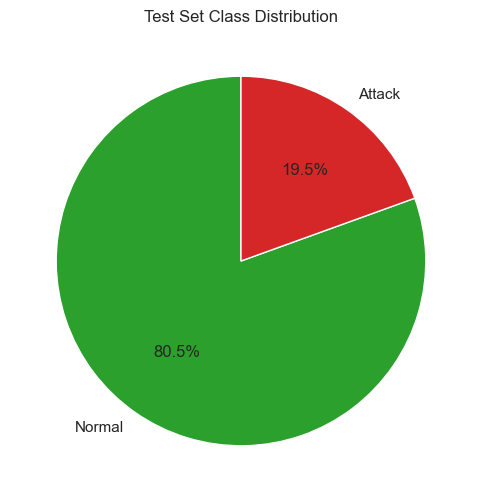

In [7]:
def plot_class_distribution_pie(df, set_name="Test"):
    counts = df['target'].value_counts()
    labels = ['Normal', 'Attack']
    colors = ['#2ca02c','#d62728']
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title(f"{set_name} Set Class Distribution")
    plt.savefig(f"plots/{set_name.lower()}_class_distribution_pie.png")
    plt.show()

plot_class_distribution_pie(test, "Test")

# Feature Encoding & Scaling 

In [8]:
categorical_cols = ['protocol_type','service','flag']
train_enc = pd.get_dummies(train, columns=categorical_cols)
test_enc = pd.get_dummies(test, columns=categorical_cols)
test_enc = test_enc.reindex(columns=train_enc.columns, fill_value=0)

X_train = train_enc.drop(columns=['label','target'])
y_train = train_enc['target']
X_test = test_enc.drop(columns=['label','target'])
y_test = test_enc['target']

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Define Machine Learning Models

In [9]:
models = {
    "LightGBM": lgb.LGBMClassifier(objective='binary', learning_rate=0.05, num_leaves=31,
                                   n_estimators=150, random_state=42, n_jobs=-1, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(n_estimators=150, random_state=42,
                                           class_weight='balanced', n_jobs=-1),
    "NaiveBayes": GaussianNB(),
    "LogisticRegression": LogisticRegression(max_iter=500, class_weight='balanced', random_state=42),
}

# SVM trained on a subset due to computational cost
subset_size = 5000
X_train_svm = X_train.sample(subset_size, random_state=42)
y_train_svm = y_train.loc[X_train_svm.index]
models["SVM"] = SVC(kernel='linear', probability=True, random_state=42)

# Train, Evaluate, and Visualize 

In [15]:
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    if name == "SVM":
        model.fit(X_train_svm, y_train_svm)
        y_train_score = model.decision_function(X_train_svm)
        y_test_score = model.decision_function(X_test)
        # Normalize decision function scores to 0-1
        y_train_score = (y_train_score - y_train_score.min()) / (y_train_score.max() - y_train_score.min())
        y_test_score = (y_test_score - y_test_score.min()) / (y_test_score.max() - y_test_score.min())
    else:
        model.fit(X_train, y_train)
        y_train_score = model.predict_proba(X_train)[:,1]
        y_test_score = model.predict_proba(X_test)[:,1]

    # Determine optimal threshold based on F1-score
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_score)
    f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
    optimal_threshold = thresholds[np.argmax(f1_scores)] if len(thresholds) > 0 else 0.5

    y_test_pred = (y_test_score >= optimal_threshold).astype(int)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc = roc_auc_score(y_test, y_test_score)
    results.append([name, acc, prec, rec, f1, roc])

    print(f"{name} Metrics: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, ROC-AUC={roc:.4f}")


Training LightGBM...
[LightGBM] [Info] Number of positive: 396743, number of negative: 97278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.245770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2536
[LightGBM] [Info] Number of data points in the train set: 494021, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
LightGBM Metrics: Accuracy=0.9489, Precision=0.9909, Recall=0.9453, F1=0.9675, ROC-AUC=0.9697

Training RandomForest...
RandomForest Metrics: Accuracy=0.9527, Precision=0.9904, Recall=0.9504, F1=0.9700, ROC-AUC=0.9641

Training NaiveBayes...
NaiveBayes Metrics: Accuracy=0.9178, Precision=0.9943, Recall=0.9030, F1=0.9465, ROC-AUC=0.9256

Training LogisticRegression...
LogisticRegression Metrics: Accuracy=0.9300, Pr

# Confusion Matrix

In [13]:
cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Normal","Attack"], yticklabels=["Normal","Attack"])
    plt.title(f"{name} Confusion Matrix")
    plt.savefig(f"plots/{name}_confusion_matrix.png")
    plt.show()

SVM Metrics: Accuracy=0.9346, Precision=0.9591, Recall=0.9596, F1=0.9594, ROC-AUC=0.9673


# Confusion Matrix

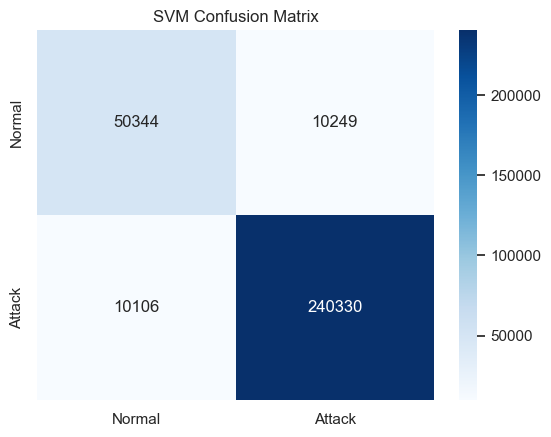

In [16]:
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Normal","Attack"], yticklabels=["Normal","Attack"])
    plt.title(f"{name} Confusion Matrix")
    plt.savefig(f"plots/{name}_confusion_matrix.png")
    plt.show()

# Summary Table 

In [17]:
results_df = pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1','ROC-AUC'])
results_df.to_csv("comparative_results.csv", index=False)
print("\nSummary of All Models:\n", results_df.to_string(index=False))


Summary of All Models:
              Model  Accuracy  Precision   Recall       F1  ROC-AUC
          LightGBM  0.948902   0.990859 0.945259 0.967522 0.969656
      RandomForest  0.952693   0.990446 0.950414 0.970017 0.964148
        NaiveBayes  0.917750   0.994280 0.903045 0.946469 0.925581
LogisticRegression  0.930000   0.987124 0.925131 0.955123 0.959352
               SVM  0.934556   0.959099 0.959646 0.959372 0.967257


# ROC Curve 

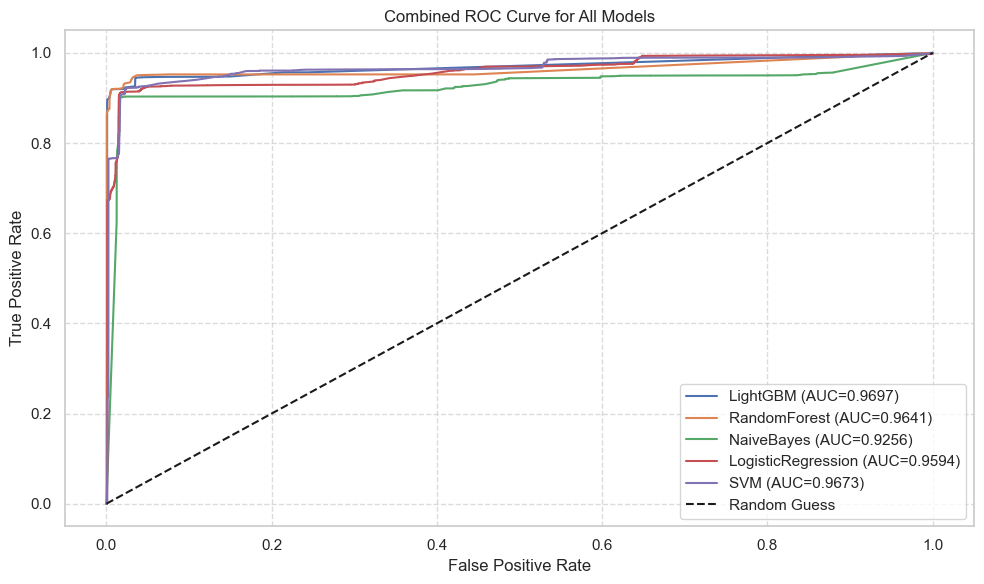

In [19]:
plt.figure(figsize=(10, 6))

for model_name in results_df['Model']:
    model = models[model_name]

    # Compute test scores
    if model_name == "SVM":
        y_test_score = model.decision_function(X_test)
        y_test_score = (y_test_score - y_test_score.min()) / (y_test_score.max() - y_test_score.min())
    else:
        y_test_score = model.predict_proba(X_test)[:, 1]

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    auc_score = roc_auc_score(y_test, y_test_score)

    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc_score:.4f})")

# Baseline
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.title("Combined ROC Curve for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig("plots/combined_roc_curve.png", dpi=150)
plt.show()

# Evaluation Metrics

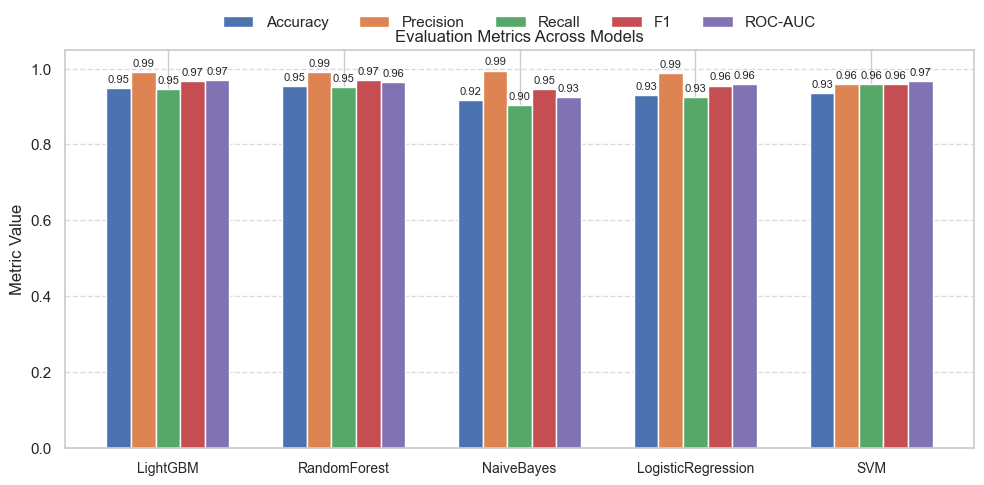

In [20]:
metrics = ['Accuracy','Precision','Recall','F1','ROC-AUC']
plt.figure(figsize=(10,5))
x = np.arange(len(results_df['Model']))
width = 0.14

for i, metric in enumerate(metrics):
    bars = plt.bar(x + i*width - (len(metrics)/2)*width + width/2, results_df[metric], width, label=metric)
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=8)

plt.xticks(x, results_df['Model'], fontsize=10)
plt.ylabel("Metric Value")
plt.ylim(0,1.05)
plt.title("Evaluation Metrics Across Models")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.12), ncol=len(metrics), frameon=False)
plt.tight_layout()
plt.savefig("plots/combined_evaluation_metrics.png")
plt.show()

# Save Models & Scaler

In [21]:
for name in ['LightGBM','RandomForest','SVM']:
    joblib.dump(models[name], f"{name}_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("All models and scaler saved successfully! All plots are in the 'plots/' folder.")    

All models and scaler saved successfully! All plots are in the 'plots/' folder.
